1.1 Exploratory Data Analysis (EDA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helper import *
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [2]:
from keras.datasets import fashion_mnist
(train_img, train_label), (test_img, test_label) = fashion_mnist.load_data()

In [3]:
x_data= np.load('./data/train_images.npy')
print("Training (meta) data: ", x_data.shape)
y_data = pd.read_csv('./data/train_labels.csv', delimiter=',')

x_test = np.load('./data/test_images.npy')
print("Test (meta) data: ", x_test.shape)

# Show first rows of data

y_data.head(10)

Training (meta) data:  (60000, 28, 28)
Test (meta) data:  (10000, 28, 28)


,label
0,9
1,0
2,0
3,3
4,0
5,2
6,7
7,2
8,5
9,5


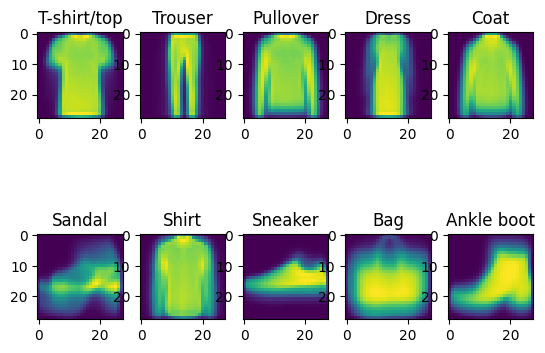

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

figure, axis = plt.subplots(2, 5)
k = 0
for i in range(2):
    for j in range(5):
        axis[i,j].imshow(x_data[y_data.label.values == k,...].mean(axis=0))
        axis[i,j].grid(False)
        axis[i,j].set_title(class_names[k])
        k += 1

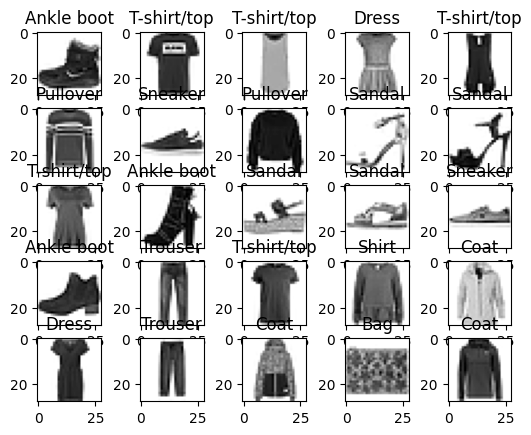

In [5]:
figure, axis = plt.subplots(5, 5)
k = 0
for i in range(5):
    for j in range(5):
        axis[i,j].imshow(x_data[k], cmap=plt.cm.binary)
        axis[i,j].grid(False)
        axis[i,j].set_title(class_names[y_data.label[k]])
        k += 1
plt.show()

Histograma de distribución de clases: las clases son equiprobables.

(array([6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000.,
        6000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

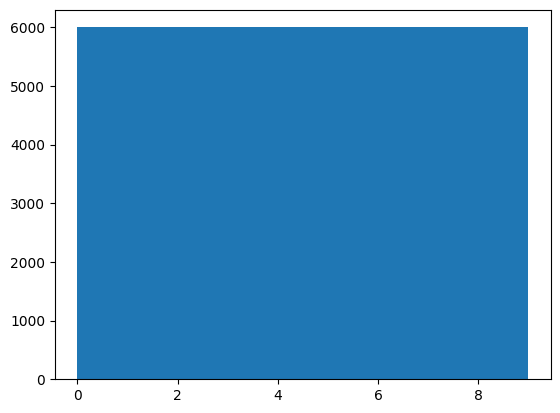

In [6]:
plt.hist(y_data['label']) 

Data splitting: train/validation datasets:
Training data — used for training the model
Validation data — used for tuning the hyperparameters and evaluate the models

In [7]:
# 20% del dataset para validación
validation = 0.20
N_validation_split = int(x_data.shape[0]*(1-validation))
# Training Set
x_train = x_data[:N_validation_split]
y_train = y_data[:N_validation_split]

# Cross Validation Set
x_val = x_data[N_validation_split:]
y_val = y_data[N_validation_split:]
print('Training set data:', x_train.shape)
print('Training labels:', y_train.shape)
print()
print('CV set data:', x_val.shape)
print('CV labels:', y_val.shape)

Training set data: (48000, 28, 28)
Training labels: (48000, 1)

CV set data: (12000, 28, 28)
CV labels: (12000, 1)


Data normalization

In [8]:
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

#Normalizing the data
#sc = StandardScaler()
#x_train = sc.fit_transform(x_train.values)

MLP: let's start!

One-hot encoding

In [9]:
y_train_categorical = np_utils.to_categorical(y_train['label'])
y_val_categorical = np_utils.to_categorical(y_val)
print(y_train_categorical.shape)
for i in range(10):
    print(y_train['label'][i], y_train_categorical[i])

(48000, 10)
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


The neural network needs to start with some weights and then iteratively update them to better values. The term kernel_initializer is a fancy term for which statistical distribution or function to use for initialising the weights. In case of statistical distribution, the library will generate numbers from that statistical distribution and use as starting weights.
https://datascience.stackexchange.com/questions/37378/what-are-kernel-initializers-and-what-is-their-significance 

Softmax regression:

In [10]:
K.clear_session()

model_0 = classification_model(       x_train.shape,
                            output_size = 10,
                            hidden_layers_size = 0, 
                            hidden_layers_units = [0],
                            hidden_activation = 'sigmoid',
                            kernel_initializer= 'random_normal',
                            dropout_rate = 0.0,
                            regularizer = None,
                            regularizer_rate = 0.001,
                            bias_initializer = 'zeros',
                            use_batch_normalization=False,
                            lr = 0.001,
                            decay = 0, 
                            out_softmax = True
                            )
model_0.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


Accuracy of model previous to training

In [11]:
score = model_0.evaluate(x_val, y_val_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])


loss:  2.5033068656921387
accuracy:  0.09650000184774399


Let's train this single layer

In [12]:
model_0.fit(x_train, 
                       y_train_categorical,
                       epochs=500, batch_size=128, 
                       verbose=1, 
                       validation_data = (x_val, y_val_categorical),
                       callbacks=[callback_EarlyStopping()],
                      )

Epoch 1/500
375/375 [==============================] - 6s 8ms/step - loss: 0.7890 - accuracy: 0.7421 - f1_m: 0.6685 - precision_m: 0.8503 - recall_m: 0.5711 - val_loss: 0.5760 - val_accuracy: 0.8054 - val_f1_m: 0.7835 - val_precision_m: 0.8744 - val_recall_m: 0.7102
Epoch 2/500
375/375 [==============================] - 2s 5ms/step - loss: 0.5379 - accuracy: 0.8216 - f1_m: 0.8051 - precision_m: 0.8808 - recall_m: 0.7421 - val_loss: 0.5121 - val_accuracy: 0.8272 - val_f1_m: 0.8179 - val_precision_m: 0.8807 - val_recall_m: 0.7637
Epoch 3/500
375/375 [==============================] - 2s 5ms/step - loss: 0.4892 - accuracy: 0.8367 - f1_m: 0.8270 - precision_m: 0.8856 - recall_m: 0.7762 - val_loss: 0.4819 - val_accuracy: 0.8369 - val_f1_m: 0.8295 - val_precision_m: 0.8823 - val_recall_m: 0.7829
Epoch 4/500
375/375 [==============================] - 2s 4ms/step - loss: 0.4655 - accuracy: 0.8436 - f1_m: 0.8355 - precision_m: 0.8865 - recall_m: 0.7904 - val_loss: 0.4589 - val_accuracy: 0.8428 

Last run: 
Epoch 50/500
375/375 - 1s - loss: 0.3607 - accuracy: 0.8726 - f1_m: 0.5126 - precision_m: 0.3493 - recall_m: 0.9634 - val_loss: 0.4167 - val_accuracy: 0.8553 - val_f1_m: 0.5116 - val_precision_m: 0.3492 - val_recall_m: 0.9578 - 1s/epoch - 4ms/step

One hidden layer model: 50 neurons.

KeyError: ''

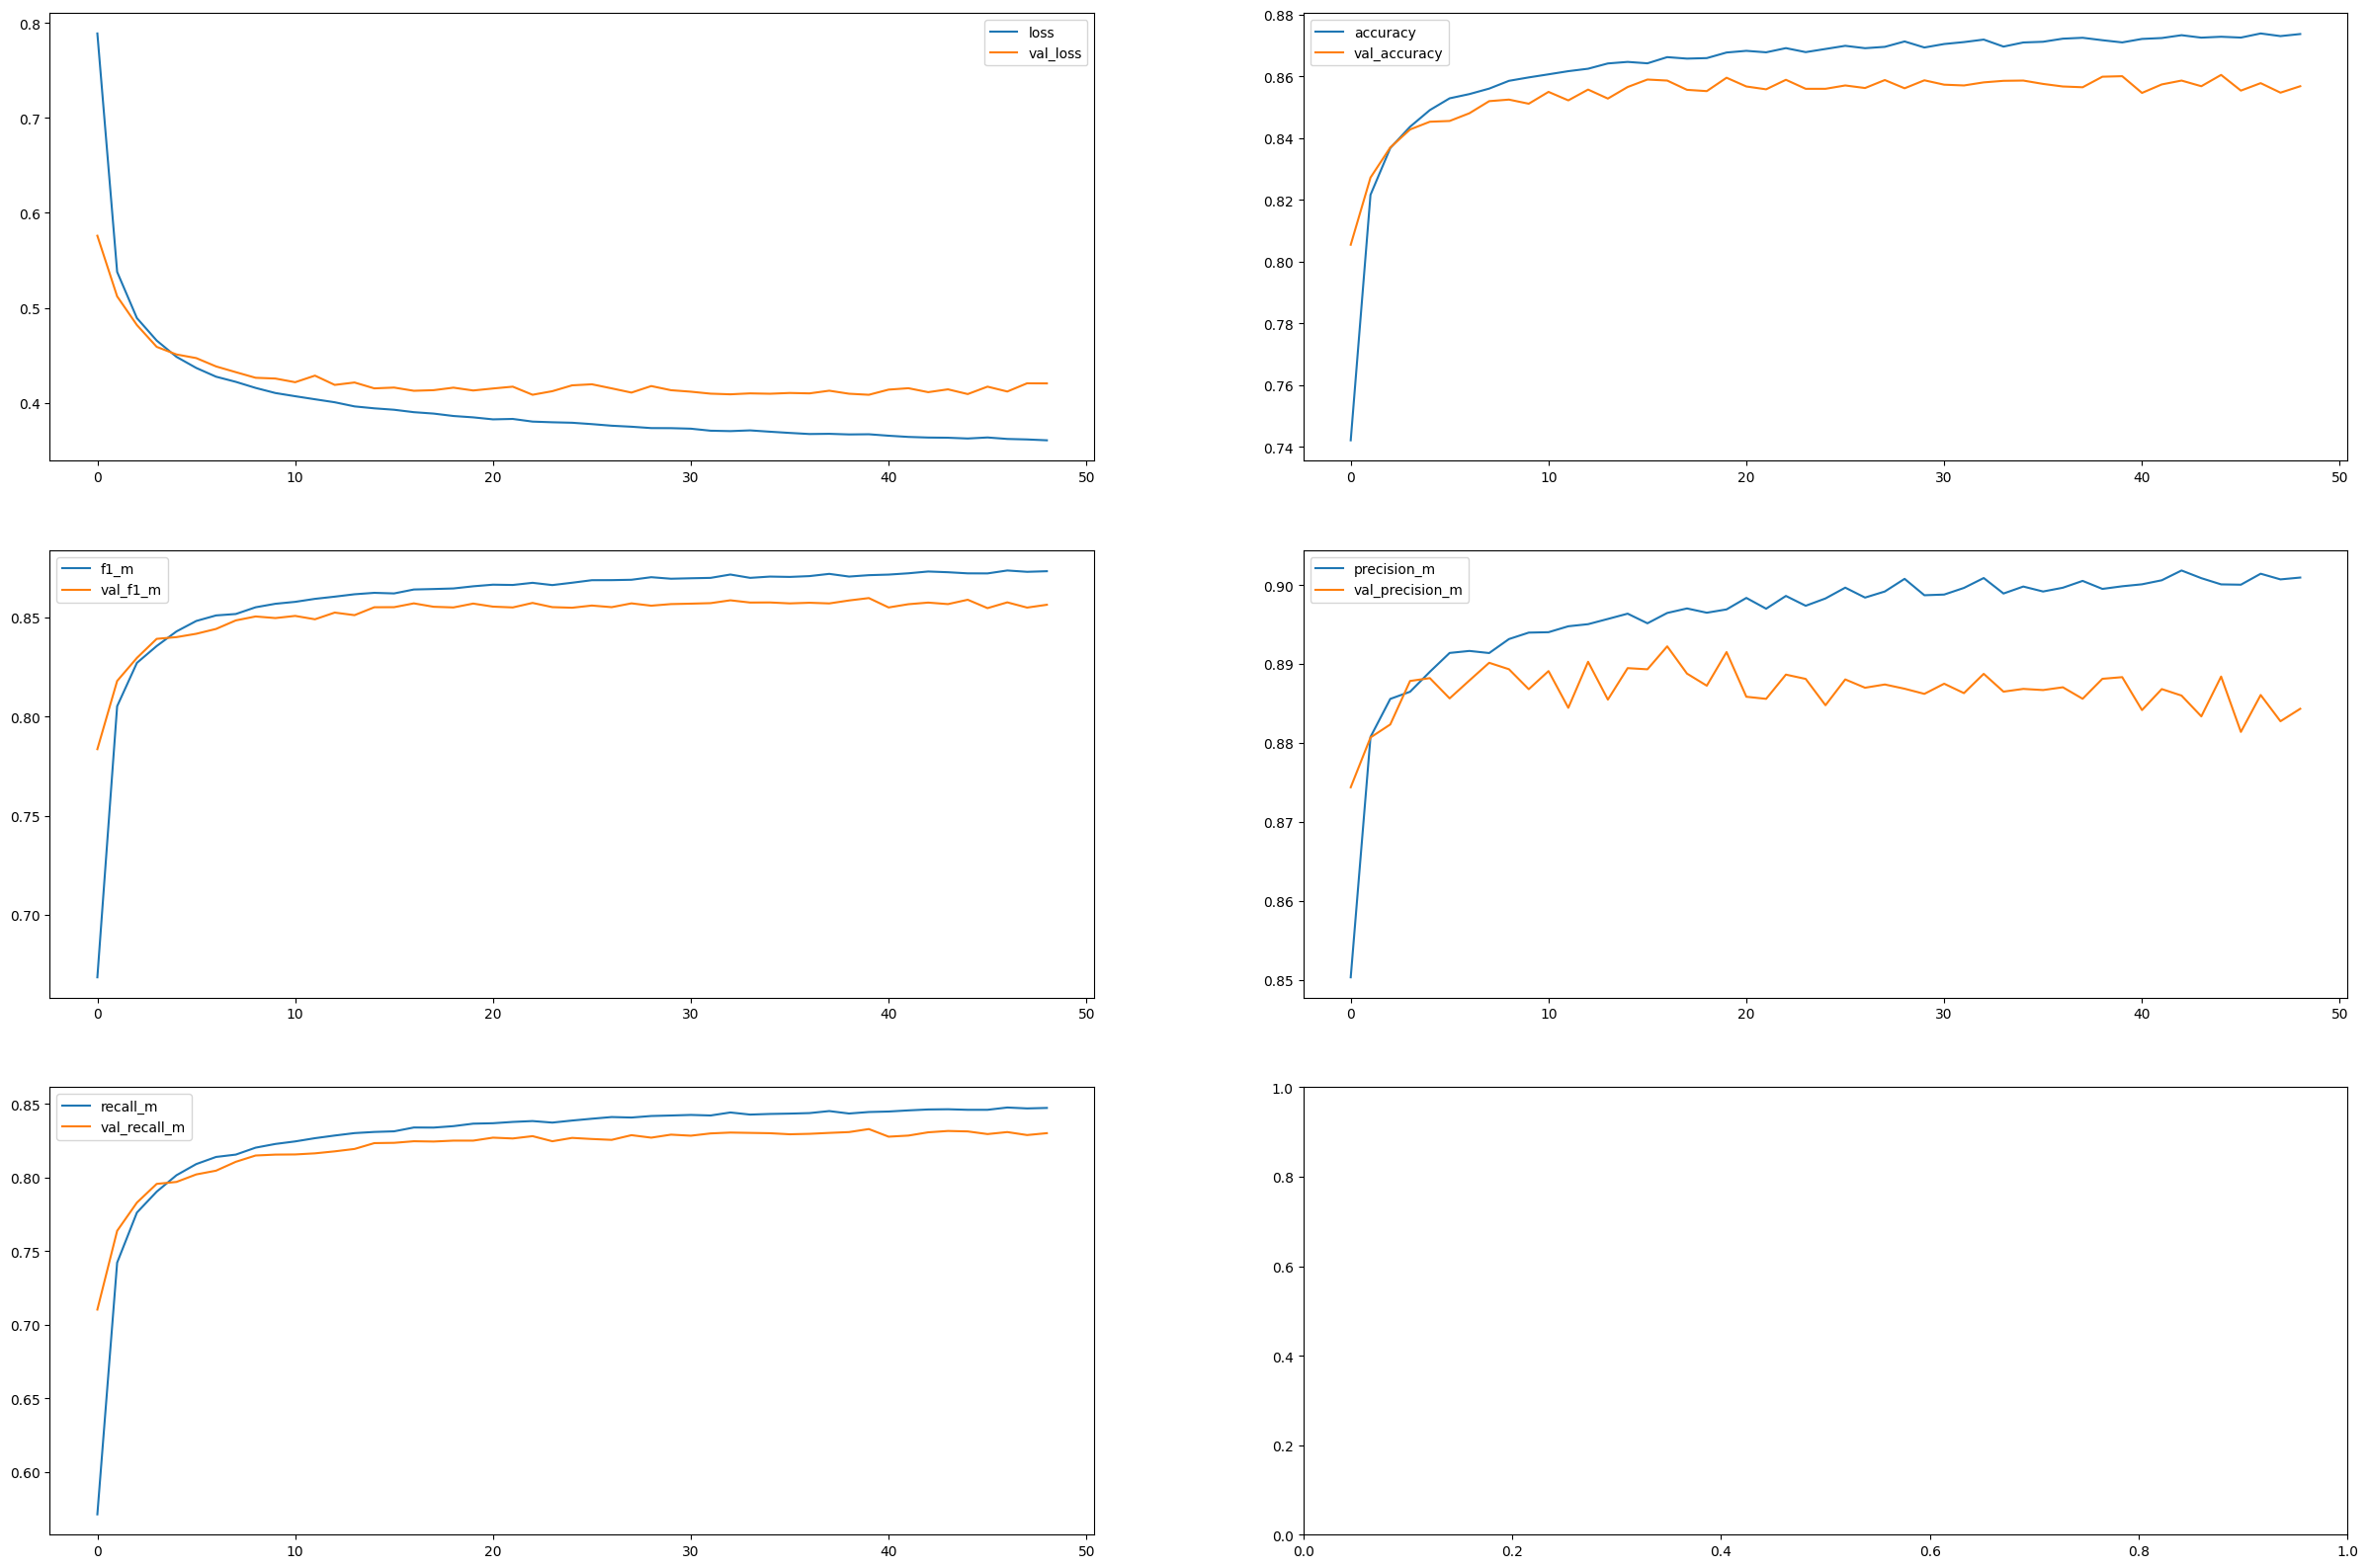

In [13]:
metrics = [[['loss', "loss"],['val_loss',"val_loss"]],
            [['accuracy', "accuracy"],['val_accuracy', "val_accuracy"]],
            [['f1_m', "f1_m"],['val_f1_m', "val_f1_m"]],
            [['precision_m', "precision_m"],['val_precision_m', "val_precision_m"]],
            [['recall_m', "recall_m"],['val_recall_m', "val_recall_m"]],
            [['', ""],['', ""]]]

f, axis = plt.subplots(3, 2, figsize=(30, 20))
k = 0
for i in range(4):
    for j in range(2):
        axis[i,j].plot(model_0.history.history[metrics[k][0][0]], label = metrics[k][0][1])
        axis[i,j].plot(model_0.history.history[metrics[k][1][0]], label = metrics[k][1][1])
        axis[i,j].legend()
        k += 1


Graficos accuracy vs cosas

Epoch 44: early stopping
Epoch 48: early stopping
Epoch 41: early stopping
Epoch 41: early stopping


C:\Users\Facu Molina\AppData\Local\Temp\ipykernel_1944\4156312842.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


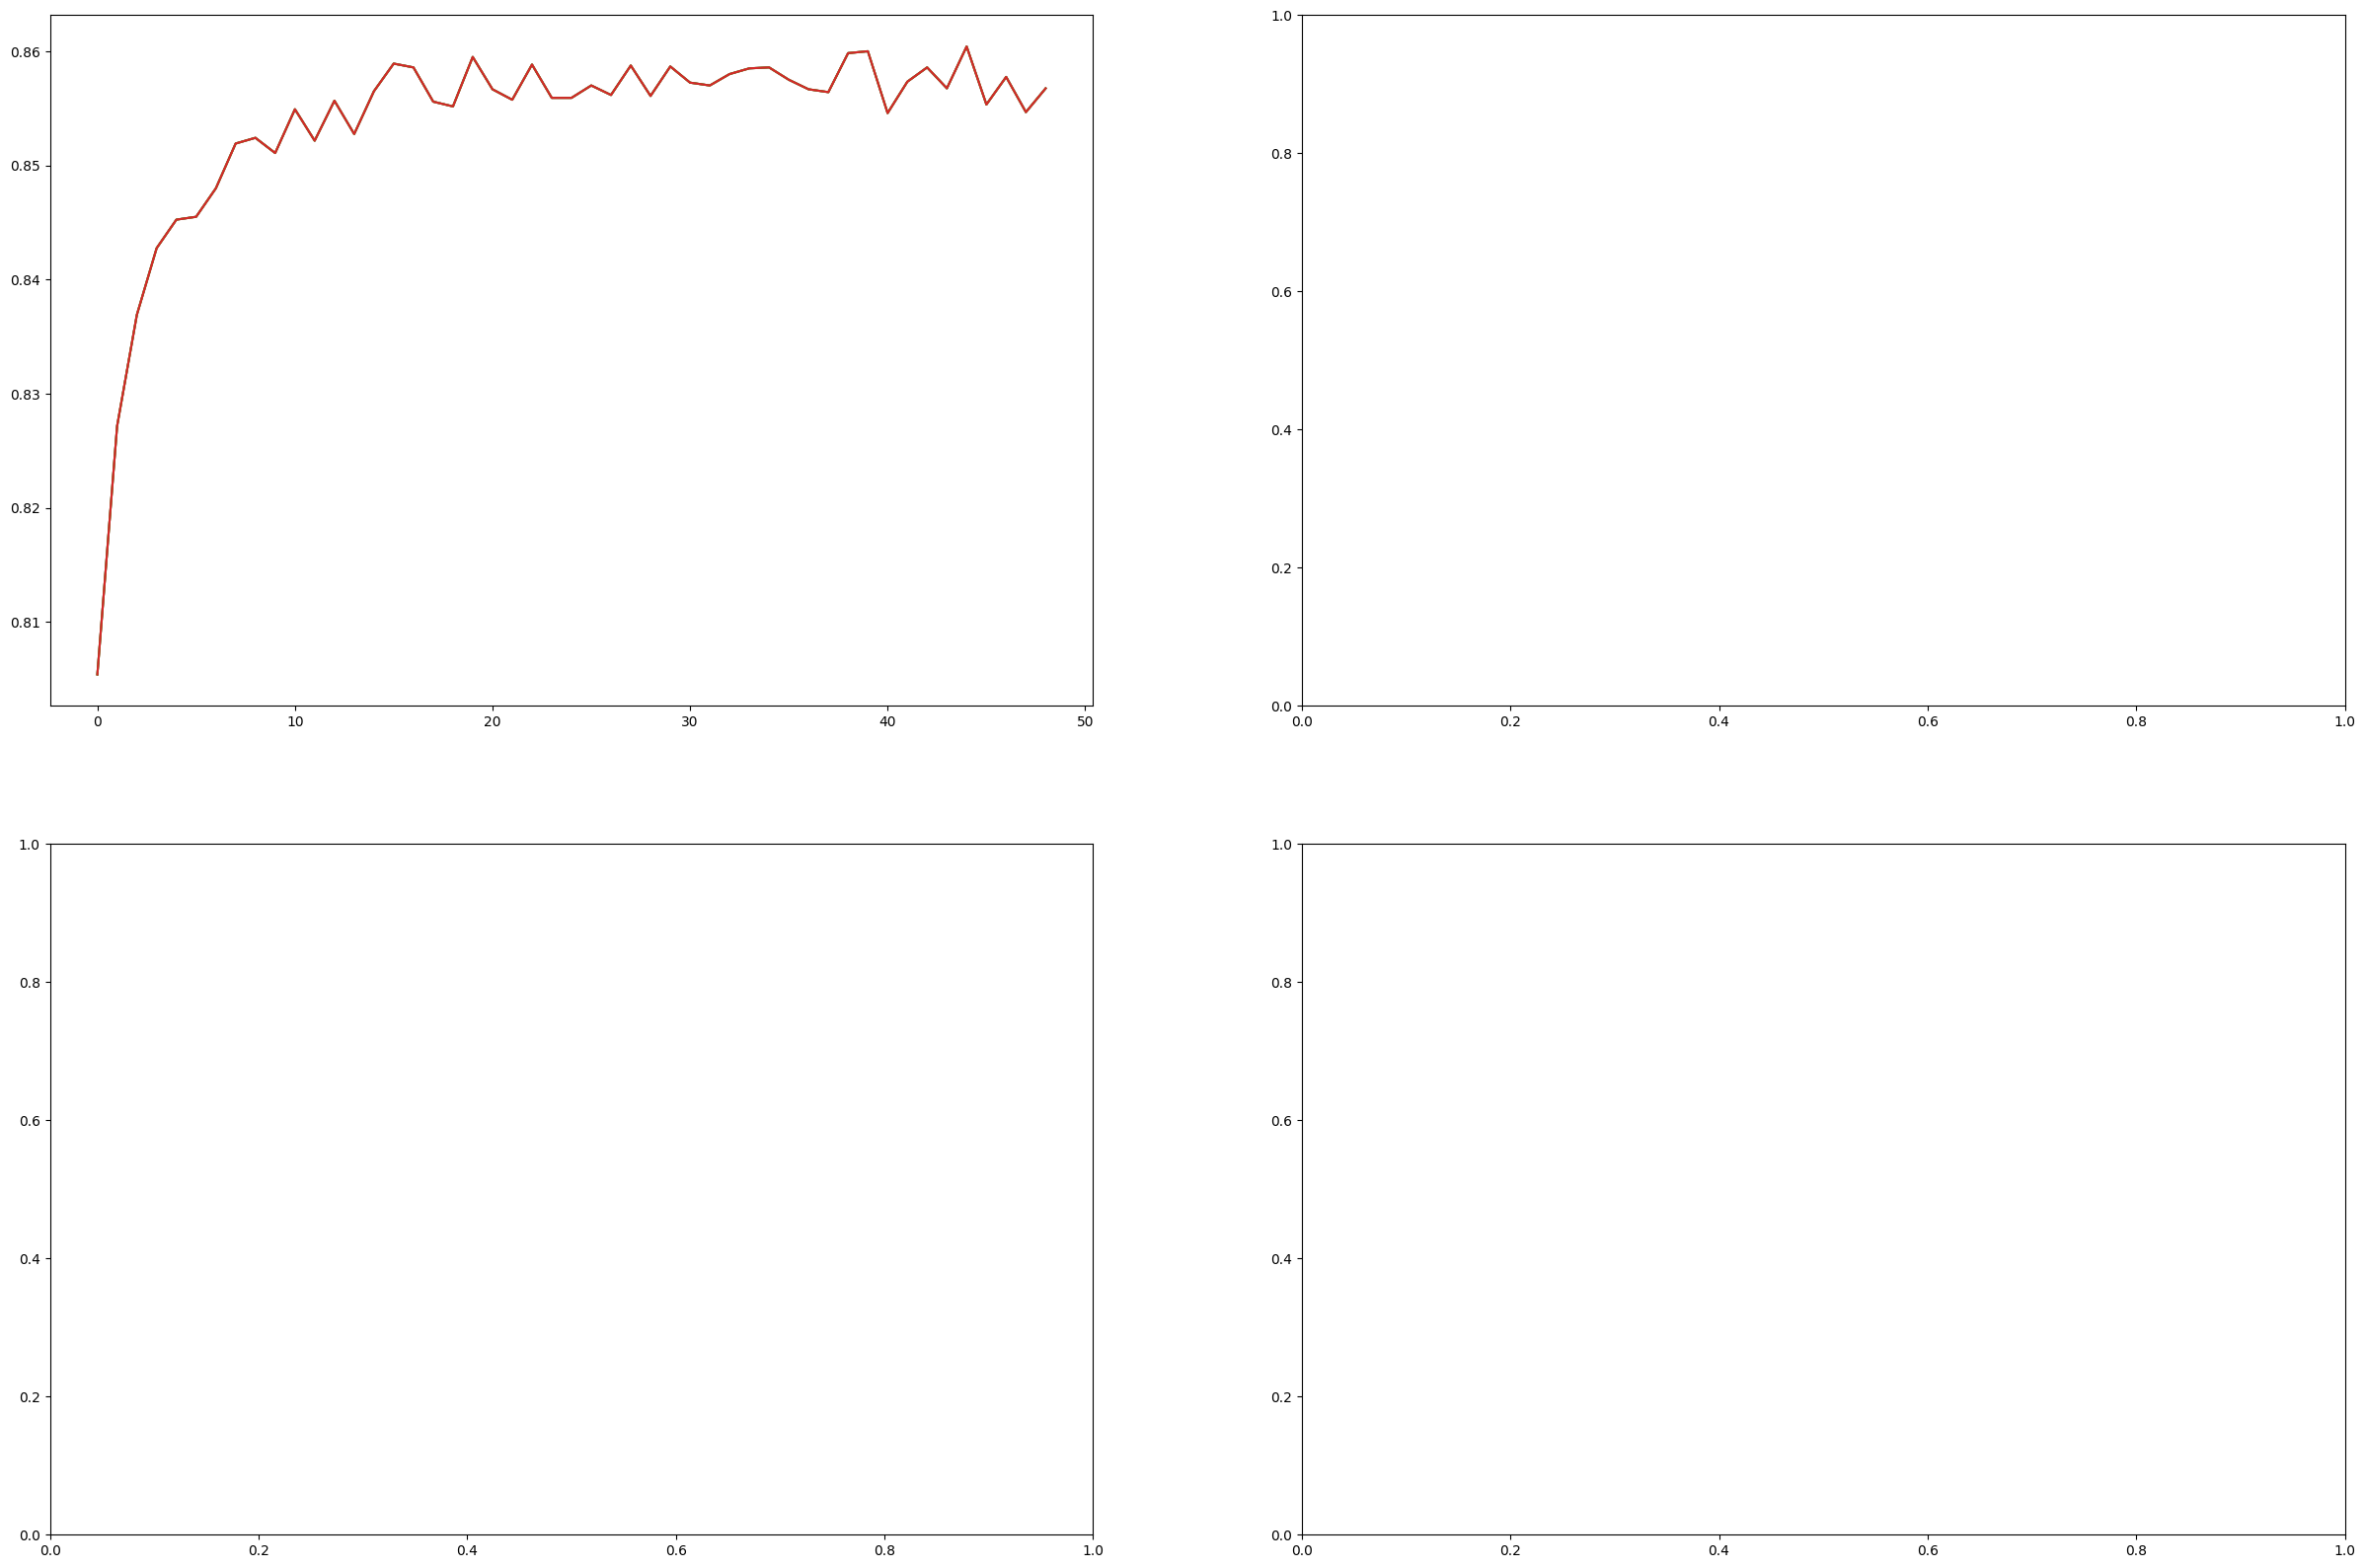

In [16]:
learning_rate = [1, 0.1, 0.01, 0.001]

f, axis = plt.subplots(2, 2, figsize=(30, 20))

for i in range(len(learning_rate)):
    K.clear_session()
    model = classification_model( x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 0, 
                                    hidden_layers_units = [0],
                                    hidden_activation = 'sigmoid',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = 0.0,
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=False,
                                    lr = learning_rate[i],
                                    decay = 0, 
                                    out_softmax = True
                                    )
    model.fit(x_train, 
                       y_train_categorical,
                       epochs=500, batch_size=128, 
                       verbose=0, 
                       validation_data = (x_val, y_val_categorical),
                       callbacks=[callback_EarlyStopping()],
                      )
    axis[0,0].plot(model_0.history.history['val_accuracy'], label = "LR = " + str(learning_rate[i]))
    axis[0,0].legend()
    
f.show()


In [17]:
K.clear_session()

model_1 = classification_model(       x_train.shape,
                            output_size = 10,
                            hidden_layers_size = 1, 
                            hidden_layers_units = [50],
                            hidden_activation = 'sigmoid',
                            kernel_initializer= 'random_normal',
                            dropout_rate = 0.0,
                            regularizer = None,
                            regularizer_rate = 0.001,
                            bias_initializer = 'zeros',
                            use_batch_normalization=False,
                            lr = 0.001,
                            decay = 0
                            )
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 50)                39250     
                                                                 
 Output (Dense)              (None, 10)                510       
                                                                 
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________


Assesment before training 

In [18]:
score_model_1 = model_1.evaluate(x_val, y_val_categorical, verbose=0)
print("loss: ", score_model_1[0])
print("accuracy: ", score_model_1[1])

loss:  2.308284282684326
accuracy:  0.10975000262260437


In [17]:
model_1.fit(    x_train, 
                y_train_categorical,
                epochs=500, batch_size=128, 
                verbose=2, 
                validation_data = (x_val, y_val_categorical),
                callbacks=[callback_EarlyStopping()]
                )

NameError: name 'model_1' is not defined

As expected, it was better! 
Epoch 46/500
375/375 - 1s - loss: 0.2056 - accuracy: 0.9261 - val_loss: 0.3182 - val_accuracy: 0.8871 - 1s/epoch - 4ms/step

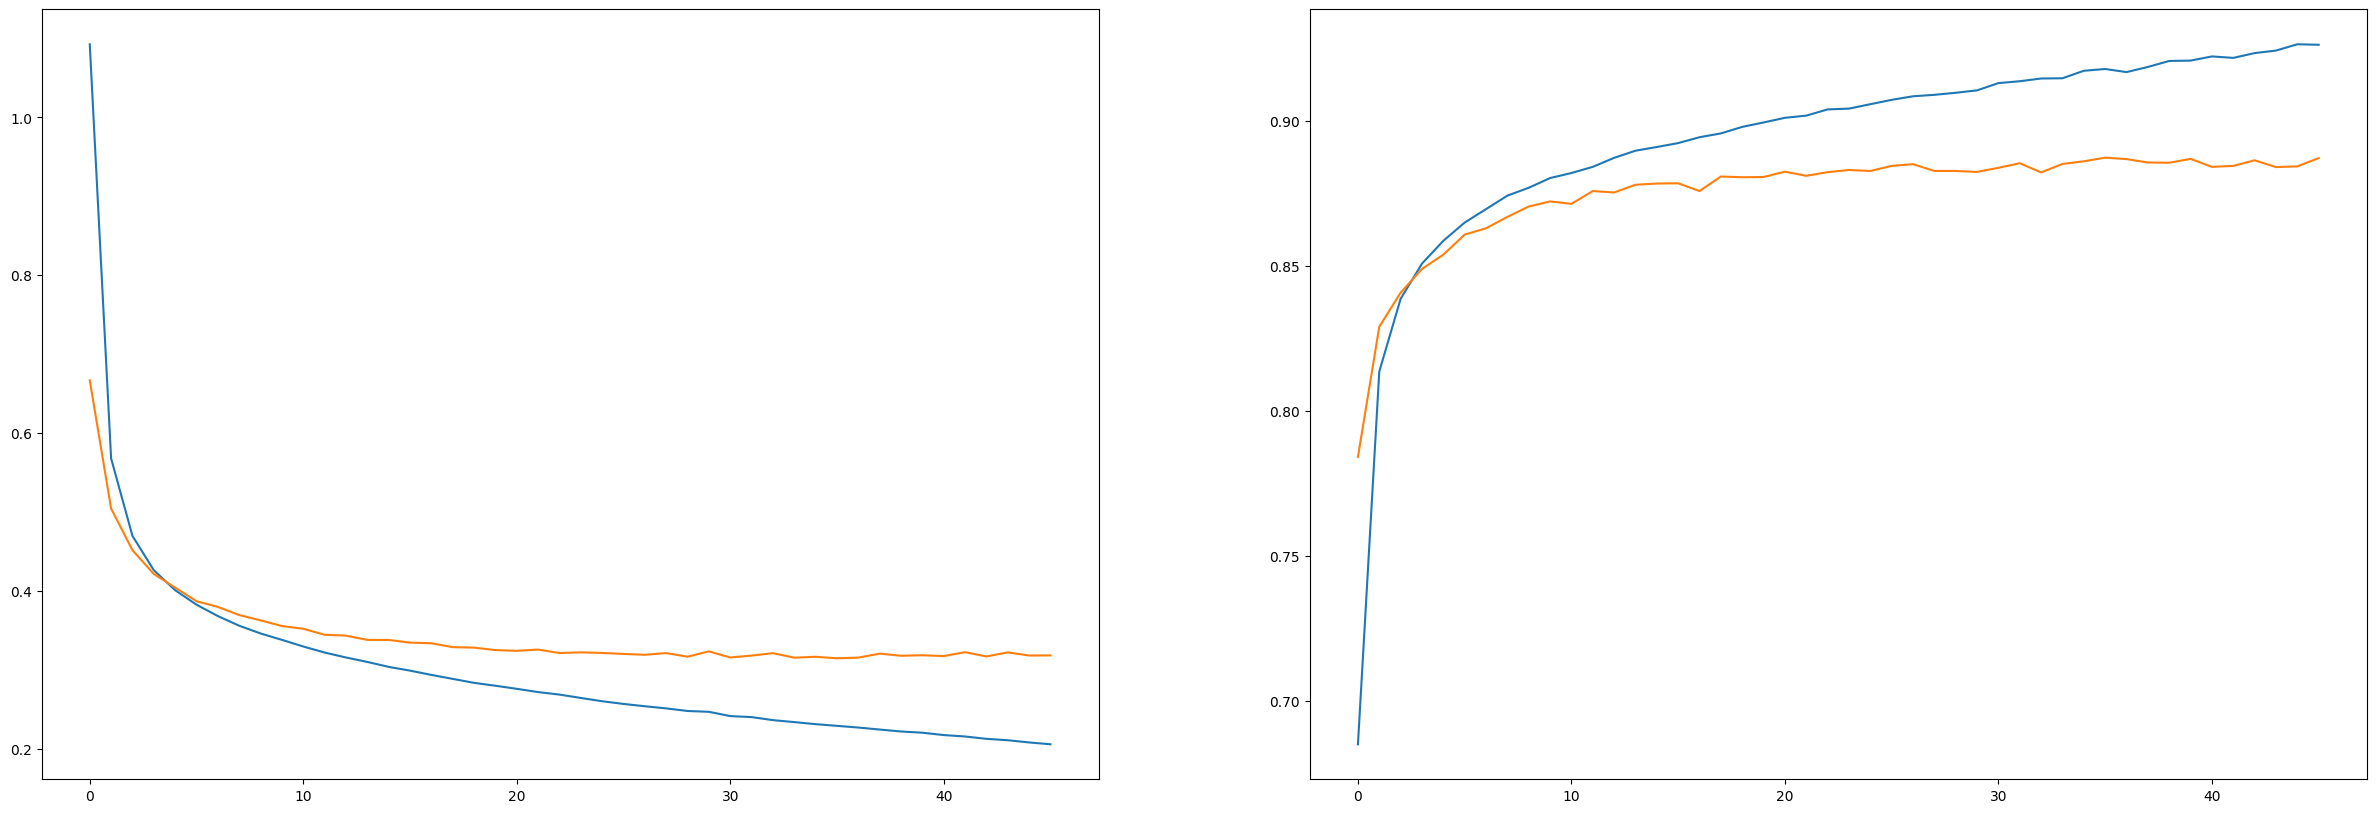

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.plot(model_1.history.history['loss'])
ax1.plot(model_1.history.history['val_loss'])
ax2.plot(model_1.history.history['accuracy'])
ax2.plot(model_1.history.history['val_accuracy'])

But there was a terrific overfitting starting from the very first epochs! Let's try to solve it before going on.

Let's add a Droupout rate of 0.25.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 50)                39250     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 Output (Dense)              (None, 10)                510       
                                                                 
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
375/375 - 3s - loss: 1.1635 - accuracy: 0.6562 - val_loss: 0.6883 - val_accuracy: 0.7833 - 3s/epoch - 7ms/step
Epoch 2/500
375/375 - 1s - loss: 0.6380 - accuracy: 0.7893 - 

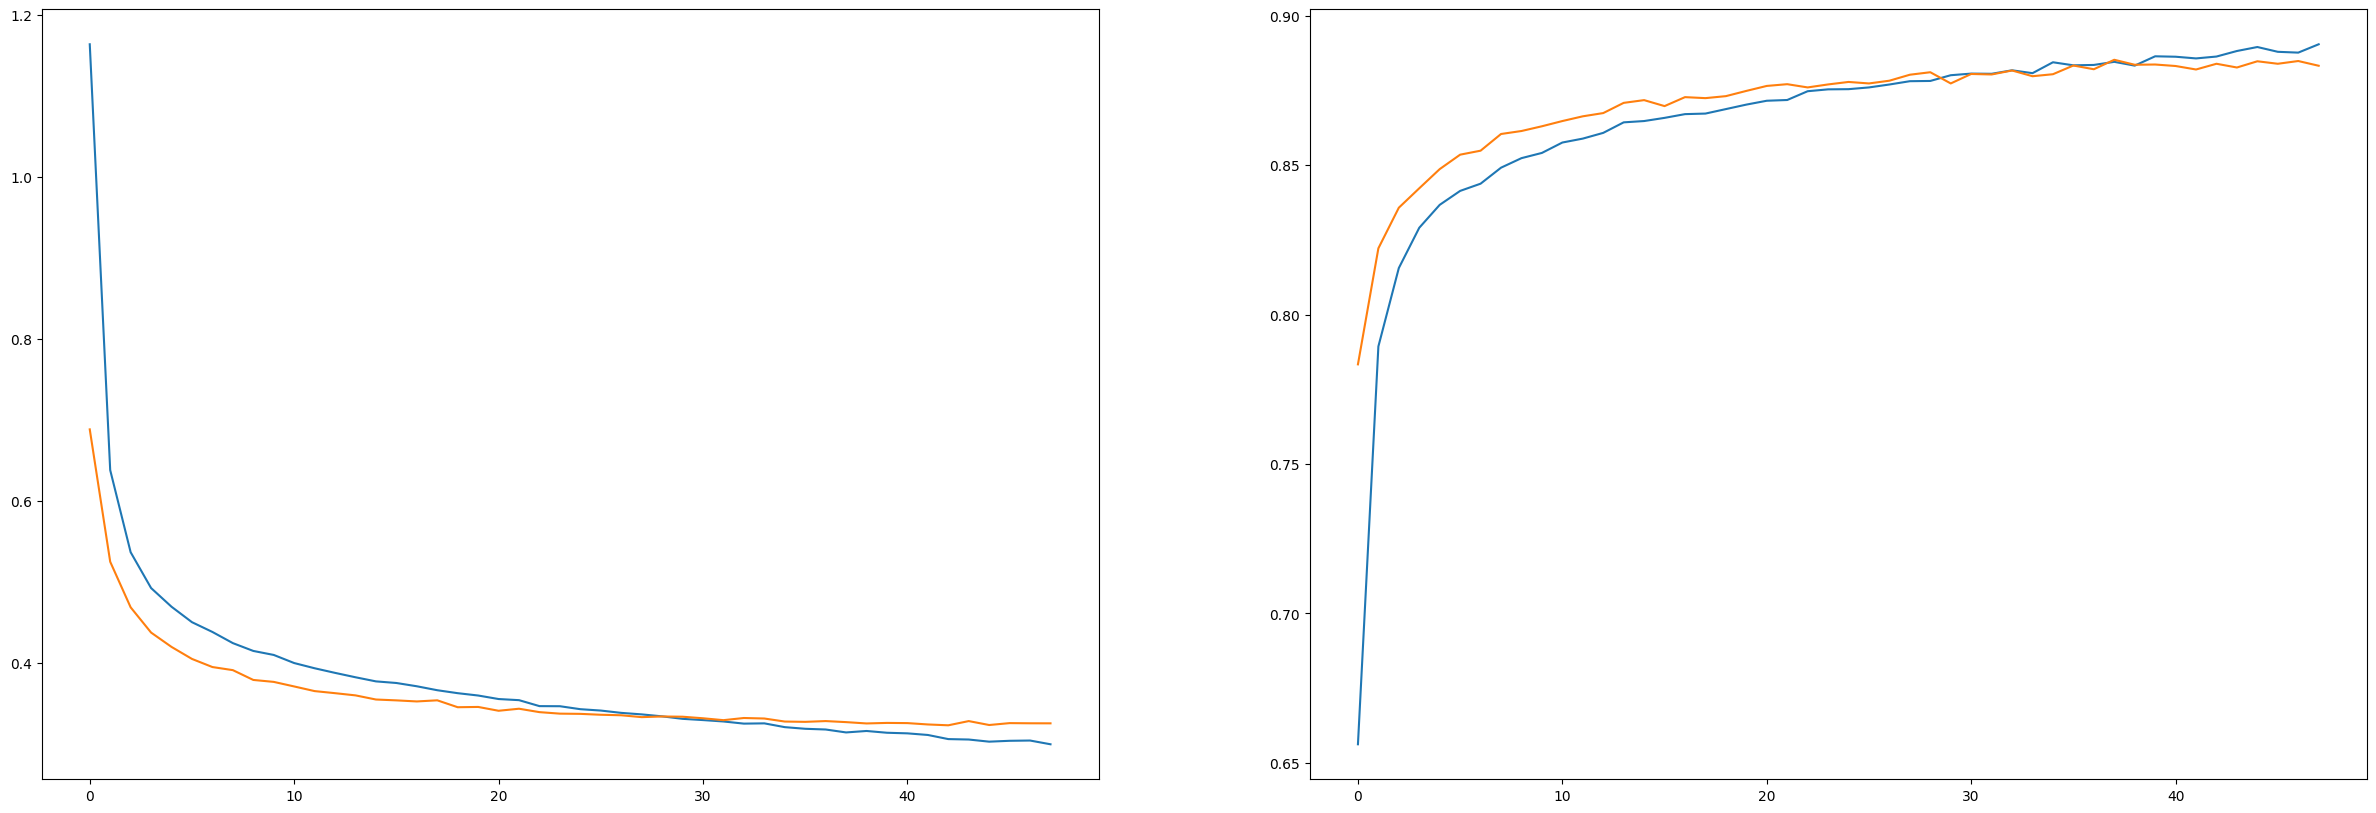

In [22]:
K.clear_session()

model_1 = classification_model(       x_train.shape,
                            output_size = 10,
                            hidden_layers_size = 1, 
                            hidden_layers_units = [50],
                            hidden_activation = 'sigmoid',
                            kernel_initializer= 'random_normal',
                            dropout_rate = 0.25,
                            regularizer = None,
                            regularizer_rate = 0.001,
                            bias_initializer = 'zeros',
                            use_batch_normalization=False,
                            lr = 0.001,
                            decay = 0
                            )
model_1.summary()

model_1.fit(    x_train, 
                y_train_categorical,
                epochs=500, batch_size=128, 
                verbose=2, 
                validation_data = (x_val, y_val_categorical),
                callbacks=[callback_EarlyStopping()]
                )

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.plot(model_1.history.history['loss'])
ax1.plot(model_1.history.history['val_loss'])
ax2.plot(model_1.history.history['accuracy'])
ax2.plot(model_1.history.history['val_accuracy'])



It went much better! Droupout for regularization ROCKS!

Ok, we've started off so far on the right foot. But before adding another layer, let's try with ReLu as the activation function. 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 50)                39250     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 Output (Dense)              (None, 10)                510       
                                                                 
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
375/375 - 2s - loss: 0.8177 - accuracy: 0.7182 - val_loss: 0.5142 - val_accuracy: 0.8223 - 2s/epoch - 7ms/step
Epoch 2/500
375/375 - 2s - loss: 0.5252 - accuracy: 0.8178 - 

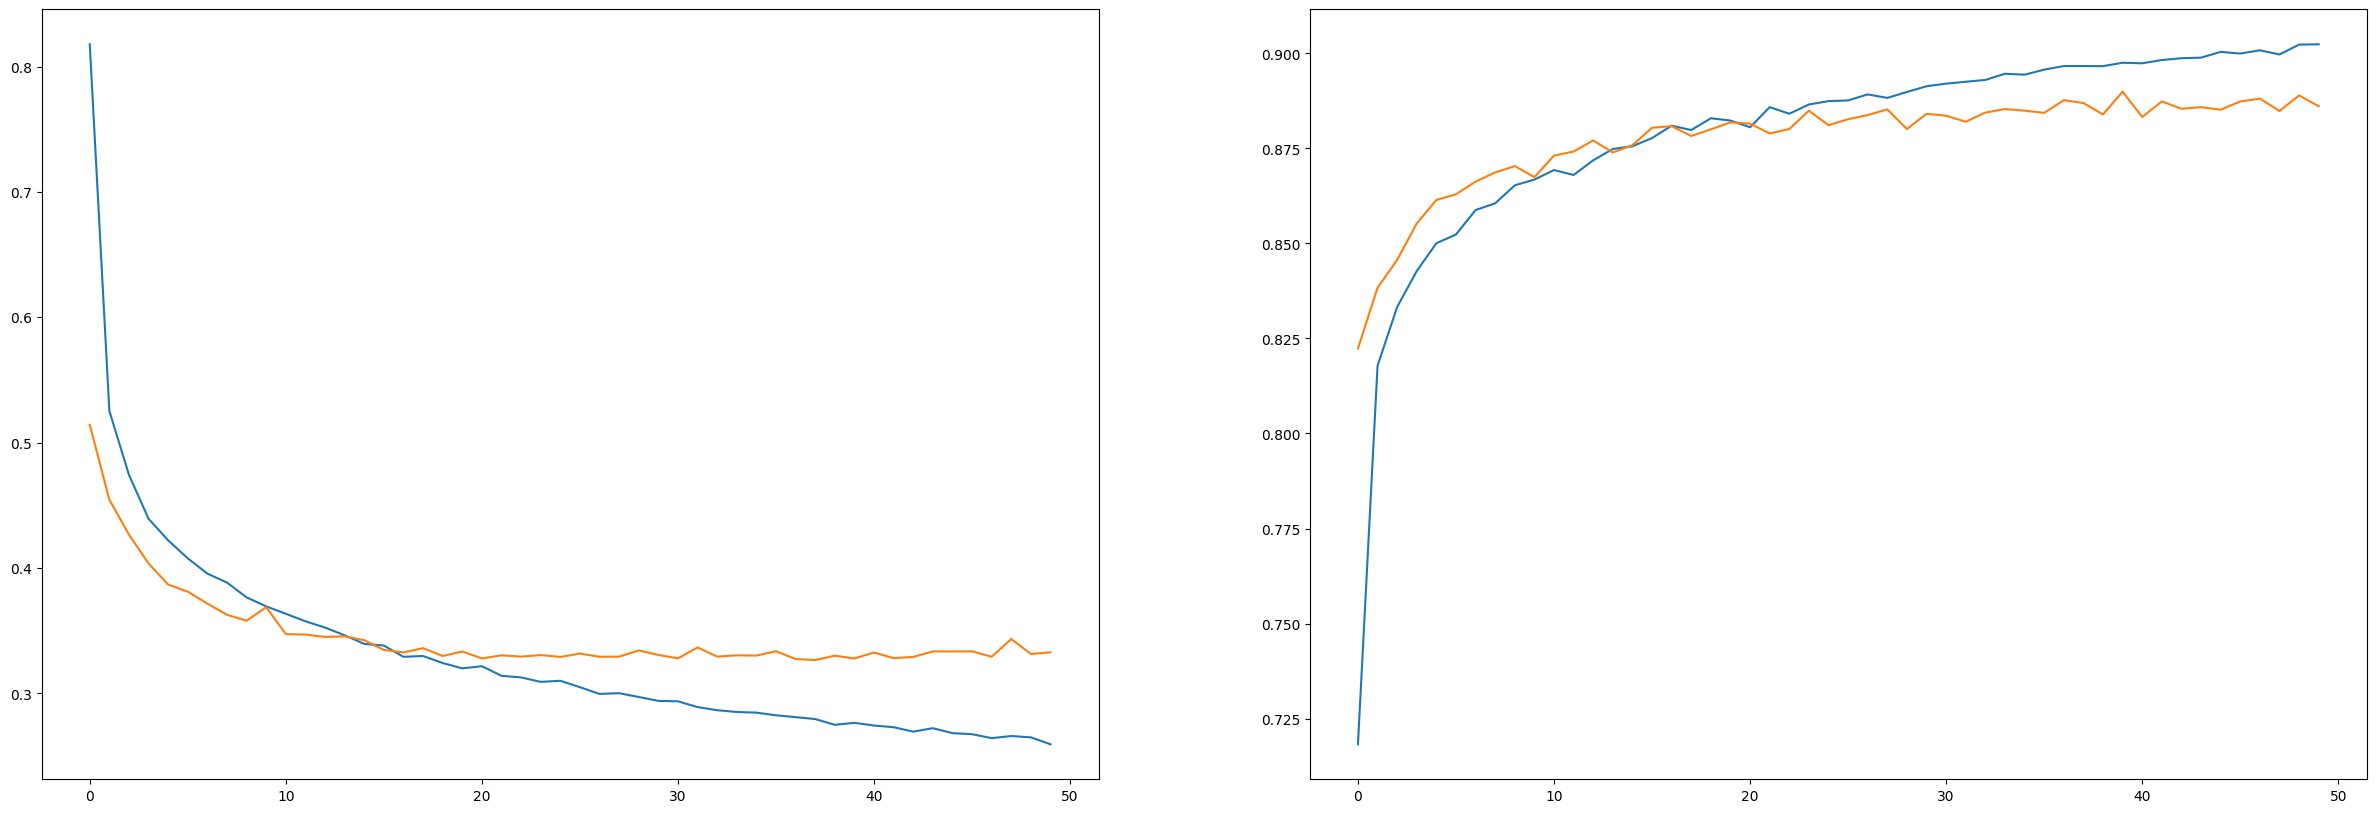

In [29]:
del model_1

K.clear_session()

model_1 = classification_model(       x_train.shape,
                            output_size = 10,
                            hidden_layers_size = 1, 
                            hidden_layers_units = [50],
                            hidden_activation = 'relu',
                            kernel_initializer= 'random_normal',
                            dropout_rate = 0.25,
                            regularizer = None,
                            regularizer_rate = 0.001,
                            bias_initializer = 'zeros',
                            use_batch_normalization=False,
                            lr = 0.001,
                            decay = 0
                            )
model_1.summary()

model_1.fit(    x_train, 
                y_train_categorical,
                epochs=500, batch_size=128, 
                verbose=2, 
                validation_data = (x_val, y_val_categorical),
                callbacks=[callback_EarlyStopping()]
                )

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.plot(model_1.history.history['loss'])
ax1.plot(model_1.history.history['val_loss'])
ax2.plot(model_1.history.history['accuracy'])
ax2.plot(model_1.history.history['val_accuracy'])

Let's add another hidden layer but this time using the Model class of keras

In [ ]:
K.clear_session()
def three_layer_model(lr=0.001, decay=0, hidden_units_1=100, hidden_units_2=100, activation='relu', droupout1 = 0.25, droupout2 = 0.25):
    output_size = 10
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(hidden_units_1, activation=activation, kernel_initializer='normal', name='middle_1'))
    model.add(Dropout(droupout1))
    model.add(Dense(hidden_units_2, activation=activation, kernel_initializer='normal', name='middle_2'))
    model.add(Dropout(droupout2))
    model.add(Dense(output_size, activation='softmax', kernel_initializer='normal', name='Output'))
    
    Adam = optimizers.Adam(learning_rate=lr, decay=decay)
    model.compile(loss = 'categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])
    return model

model_three_layers = three_layer_model()

In [ ]:
model_three_layers = three_layer_model(lr=0.001, hidden_units_1=500, hidden_units_2=50, activation='relu', droupout1 = 0.25, droupout2 = 0.10) 
model_three_layers.fit(x_train, 
          y_train_categorical ,
          epochs=500, batch_size=256, 
          verbose=2, 
          validation_data=(x_val, y_val_categorical),
          callbacks=[callback])

Epoch 1/500
188/188 - 4s - loss: 1.5719 - accuracy: 0.4514 - val_loss: 1.0095 - val_accuracy: 0.6058 - 4s/epoch - 22ms/step
Epoch 2/500
188/188 - 3s - loss: 0.9379 - accuracy: 0.6408 - val_loss: 0.7942 - val_accuracy: 0.7126 - 3s/epoch - 15ms/step
Epoch 3/500
188/188 - 3s - loss: 0.7881 - accuracy: 0.7099 - val_loss: 0.6876 - val_accuracy: 0.7413 - 3s/epoch - 16ms/step
Epoch 4/500
188/188 - 3s - loss: 0.6922 - accuracy: 0.7452 - val_loss: 0.6203 - val_accuracy: 0.7675 - 3s/epoch - 15ms/step
Epoch 5/500
188/188 - 3s - loss: 0.6415 - accuracy: 0.7641 - val_loss: 0.5863 - val_accuracy: 0.7875 - 3s/epoch - 15ms/step
Epoch 6/500
188/188 - 3s - loss: 0.6025 - accuracy: 0.7780 - val_loss: 0.5536 - val_accuracy: 0.7968 - 3s/epoch - 15ms/step
Epoch 7/500
188/188 - 3s - loss: 0.5742 - accuracy: 0.7924 - val_loss: 0.5329 - val_accuracy: 0.8059 - 3s/epoch - 15ms/step
Epoch 8/500
188/188 - 3s - loss: 0.5514 - accuracy: 0.8015 - val_loss: 0.5139 - val_accuracy: 0.8107 - 3s/epoch - 14ms/step
Epoch 9/

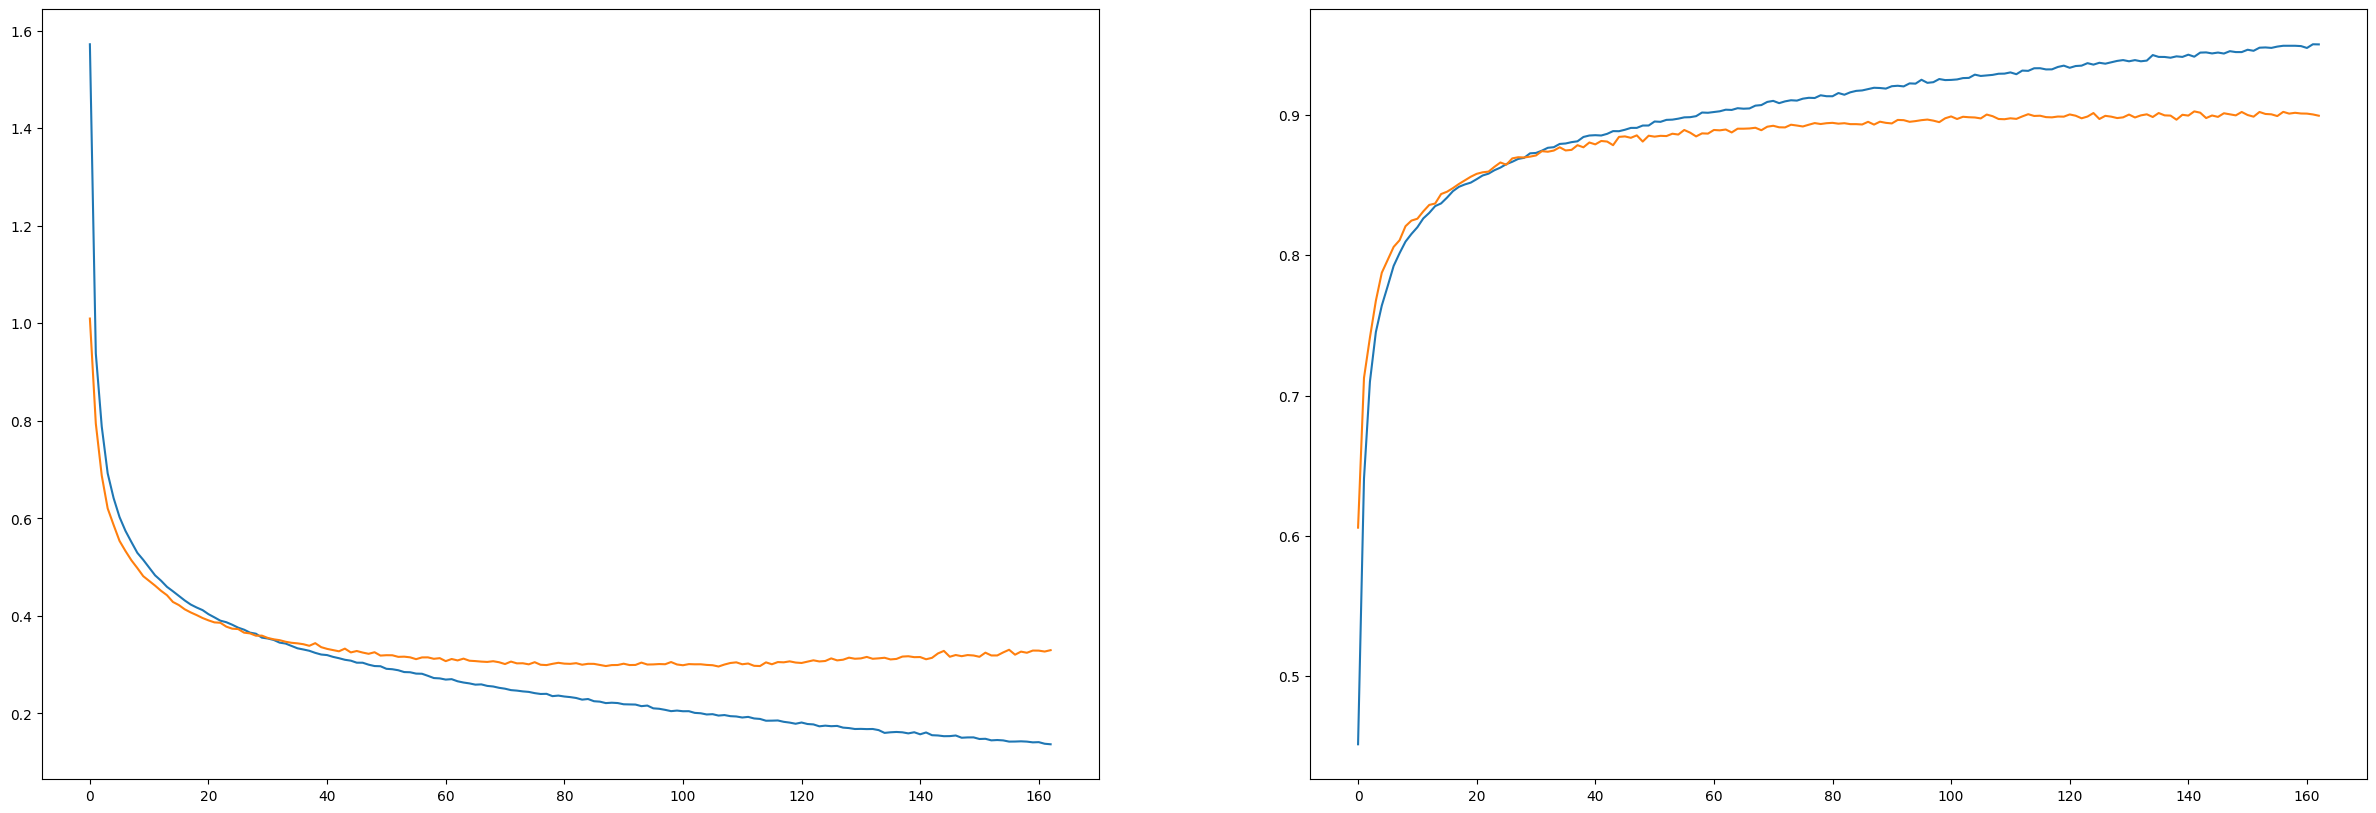

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.plot(model_three_layers.history.history['loss'])
ax1.plot(model_three_layers.history.history['val_loss'])
ax2.plot(model_three_layers.history.history['accuracy'])
ax2.plot(model_three_layers.history.history['val_accuracy'])

In [ ]:
K.clear_session()
def four_layer_model(lr=0.001, decay=0, hidden_units_1=100, hidden_units_2=100, hidden_units_3 = 2, activation='relu', droupout1 = 0.25, droupout2 = 0.25, droupout3 = 0.25):
    output_size = 10
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(hidden_units_1, activation=activation, kernel_initializer='normal', name='middle_1', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(droupout1))
    model.add(Dense(hidden_units_2, activation=activation, kernel_initializer='normal', name='middle_2', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(droupout2))
    model.add(Dense(hidden_units_3, activation=activation, kernel_initializer='normal', name='middle_3', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(droupout3))
    model.add(Dense(output_size, activation='sigmoid', kernel_initializer='normal', name='Output'))
    
    Adam = optimizers.Adam(learning_rate=lr, decay=decay)
    model.compile(loss = 'categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])
    return model

model_four_layers = four_layer_model()

In [ ]:
K.clear_session()
model_four_layers = four_layer_model(lr=0.001, hidden_units_1=500, hidden_units_2=250, hidden_units_3=50, activation='relu', droupout1 = 0.10, droupout2 = 0.10, droupout3 = 0.10) 
model_four_layers.summary()
model_four_layers.fit(x_train, 
          y_train_categorical ,
          epochs=500, batch_size=256, 
          verbose=2, 
          validation_data=(x_val, y_val_categorical),
          callbacks=[callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 middle_1 (Dense)            (None, 500)               392500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 middle_2 (Dense)            (None, 250)               125250    
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 middle_3 (Dense)            (None, 50)                12550     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0

KeyboardInterrupt: 

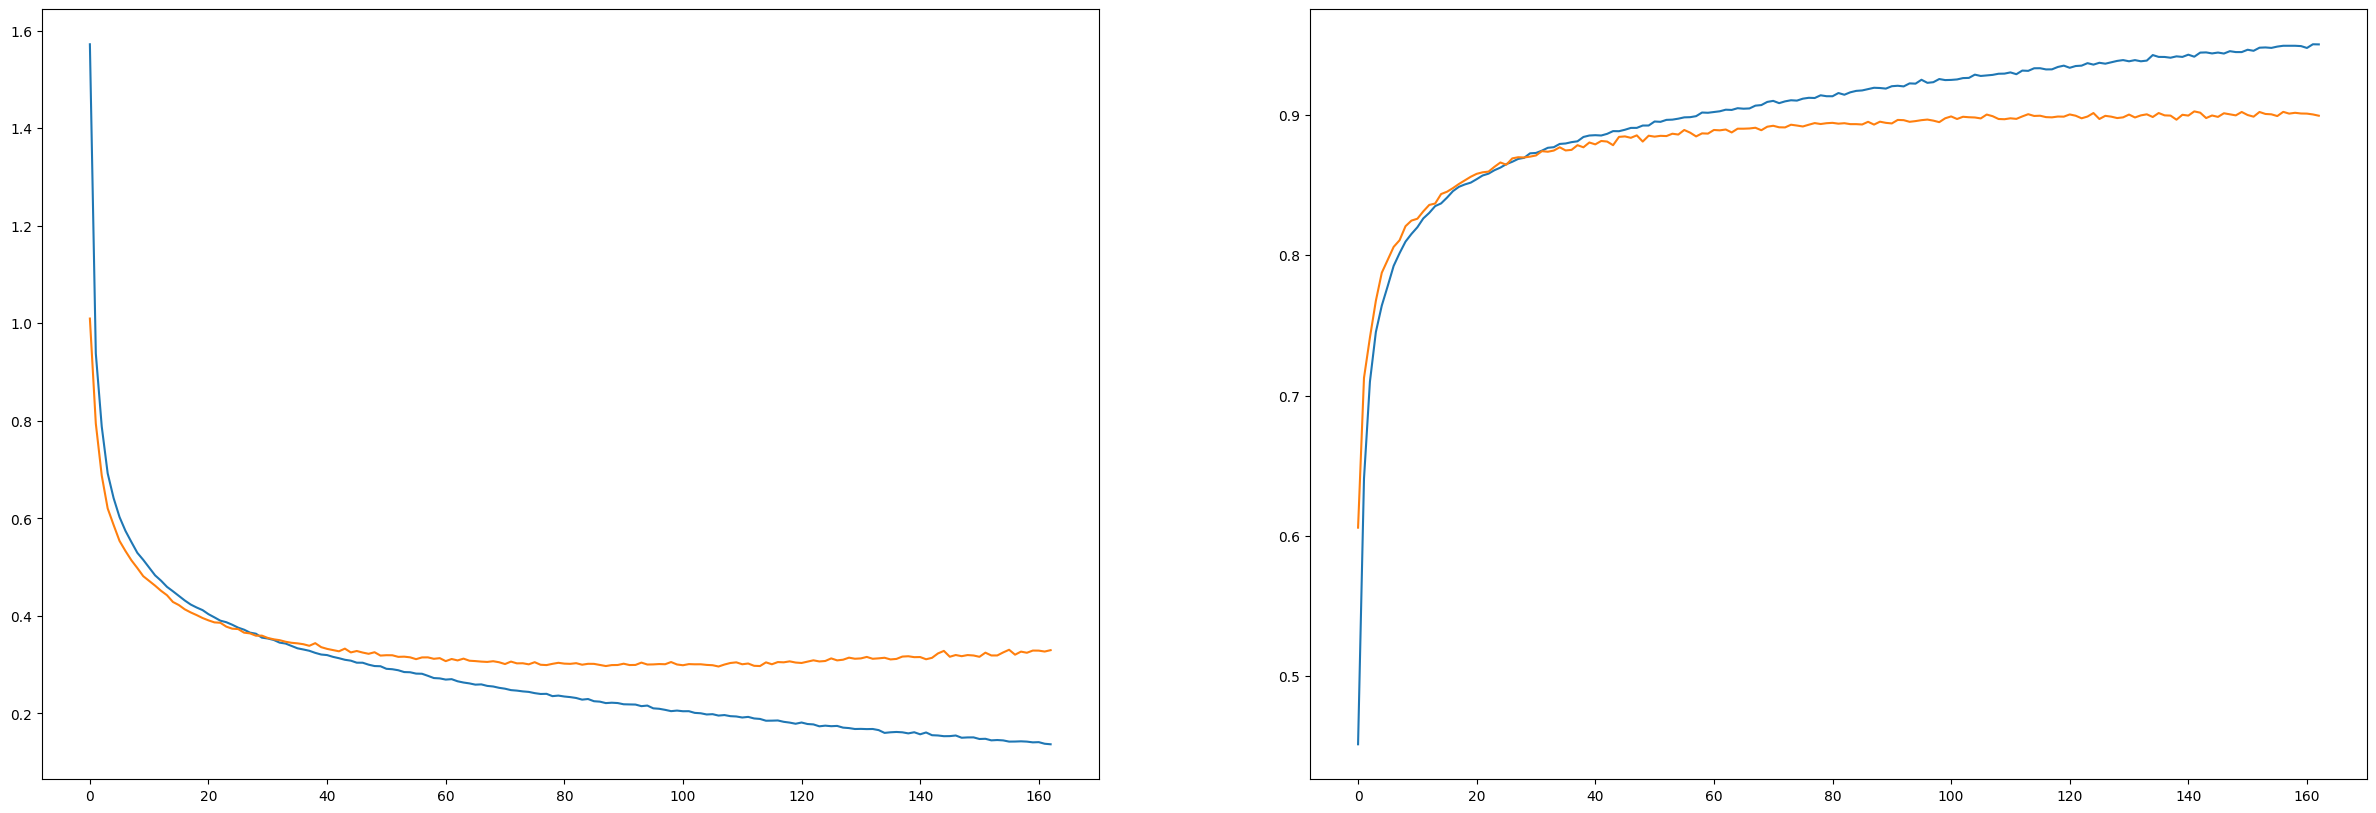

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.plot(model_four_layers.history.history['loss'])
ax1.plot(model_four_layers.history.history['val_loss'])
ax2.plot(model_four_layers.history.history['accuracy'])
ax2.plot(model_four_layers.history.history['val_accuracy'])

In [ ]:
K.clear_session()
def five_layer_model(lr=0.001, decay=0, hidden_units_1=250, hidden_units_2=150, hidden_units_3 = 100, hidden_units_4 = 50, activation='relu', droupout1 = 0.25, droupout2 = 0.25, droupout3 = 0.25, droupout4 = 0.25):
    output_size = 10
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(hidden_units_1, activation=activation, kernel_initializer='normal', name='middle_1'))
    model.add(Dropout(droupout1))
    model.add(Dense(hidden_units_2, activation=activation, kernel_initializer='normal', name='middle_2'))
    model.add(Dropout(droupout2))
    model.add(Dense(hidden_units_3, activation=activation, kernel_initializer='normal', name='middle_3'))
    model.add(Dropout(droupout3))
    model.add(Dense(hidden_units_4, activation=activation, kernel_initializer='normal', name='middle_4'))
    model.add(Dropout(droupout4))
    model.add(Dense(output_size, activation='sigmoid', kernel_initializer='normal', name='Output'))
    
    Adam = optimizers.Adam(learning_rate=lr, decay=decay)
    model.compile(loss = 'categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])
    return model

model_five_layers = five_layer_model()

In [ ]:
K.clear_session()
model_five_layers = five_layer_model(lr=0.001, hidden_units_1=500, hidden_units_2=250, hidden_units_3=150, hidden_units_4=50, activation='relu', droupout1 = 0.20, droupout2 = 0.20, droupout3 = 0.20, droupout4 = 0.20) 
model_five_layers.summary()
model_five_layers.fit(x_train, 
          y_train_categorical ,
          epochs=500, batch_size=128, 
          verbose=2, 
          validation_data=(x_val, y_val_categorical),
          callbacks=[callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 middle_1 (Dense)            (None, 250)               196250    
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 middle_2 (Dense)            (None, 150)               37650     
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 middle_3 (Dense)            (None, 100)               15100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0

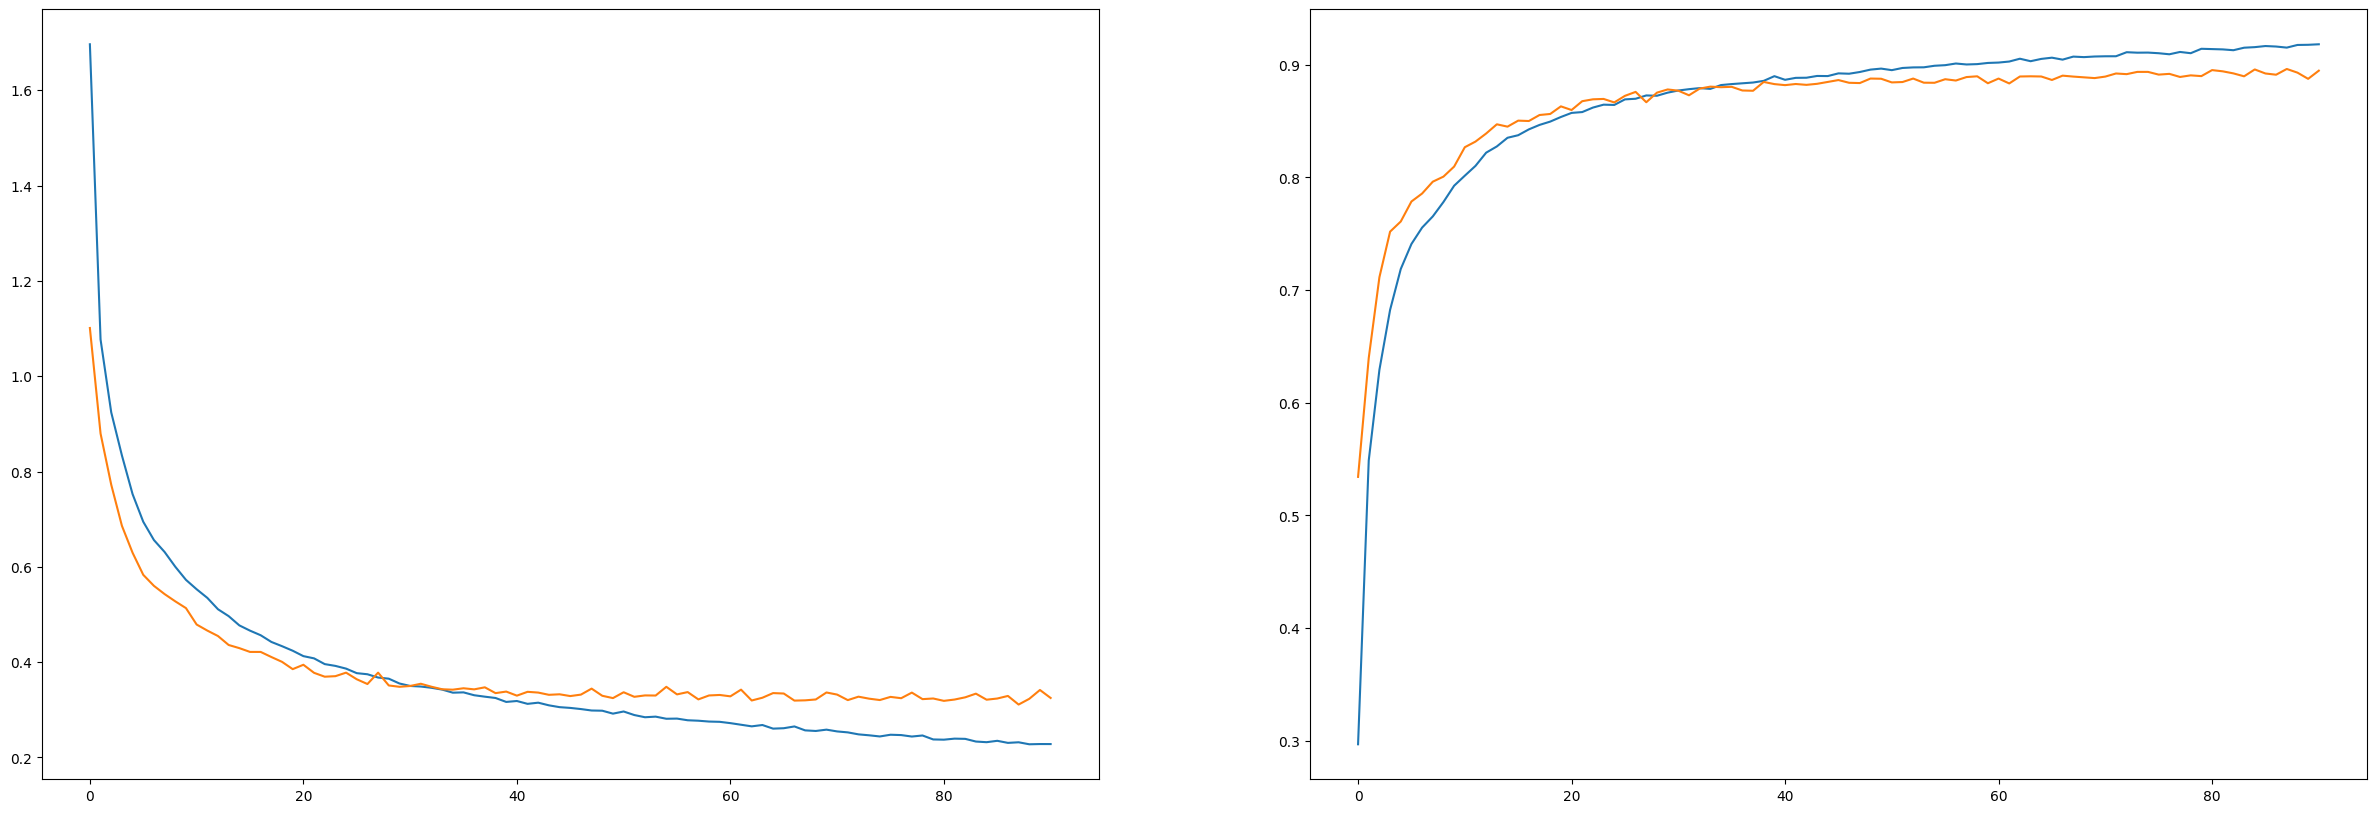

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.plot(model_five_layers.history.history['loss'])
ax1.plot(model_five_layers.history.history['val_loss'])
ax2.plot(model_five_layers.history.history['accuracy'])
ax2.plot(model_five_layers.history.history['val_accuracy'])

In [ ]:
K.clear_session()
def six_layer_model(lr=0.001, decay=0, hidden_units_1=250, hidden_units_2=150, hidden_units_3 = 100, hidden_units_4 = 50, hidden_units_5 = 50, activation='relu', droupout1 = 0.25, droupout2 = 0.25, droupout3 = 0.25, droupout4 = 0.25, droupout5 = 0.25):
    output_size = 10
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(hidden_units_1, activation=activation, kernel_initializer='normal', name='middle_1'))
    model.add(Dropout(droupout1))
    model.add(Dense(hidden_units_2, activation=activation, kernel_initializer='normal', name='middle_2'))
    model.add(Dropout(droupout2))
    model.add(Dense(hidden_units_3, activation=activation, kernel_initializer='normal', name='middle_3'))
    model.add(Dropout(droupout3))
    model.add(Dense(hidden_units_4, activation=activation, kernel_initializer='normal', name='middle_4'))
    model.add(Dropout(droupout4))
    model.add(Dense(hidden_units_5, activation=activation, kernel_initializer='normal', name='middle_5'))
    model.add(Dropout(droupout5))
    model.add(Dense(output_size, activation='sigmoid', kernel_initializer='normal', name='Output'))
    
    Adam = optimizers.Adam(learning_rate=lr, decay=decay)
    model.compile(loss = 'categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])
    return model

model_six_layers = six_layer_model()

In [ ]:
K.clear_session()
model_six_layers = six_layer_model(lr=0.001, hidden_units_1=1000, hidden_units_2=250, hidden_units_3=200, hidden_units_4=100, hidden_units_5=50, activation='relu', droupout1 = 0.20, droupout2 = 0.20, droupout3 = 0.20, droupout4 = 0.20, droupout5 = 0.20) 
model_six_layers.summary()
model_six_layers.fit(x_train, 
          y_train_categorical ,
          epochs=500, batch_size=128, 
          verbose=2, 
          validation_data=(x_val, y_val_categorical),
          callbacks=[callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 middle_1 (Dense)            (None, 1000)              785000    
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 middle_2 (Dense)            (None, 250)               250250    
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 middle_3 (Dense)            (None, 200)               50200     
                                                                 
 dropout_2 (Dropout)         (None, 200)               0

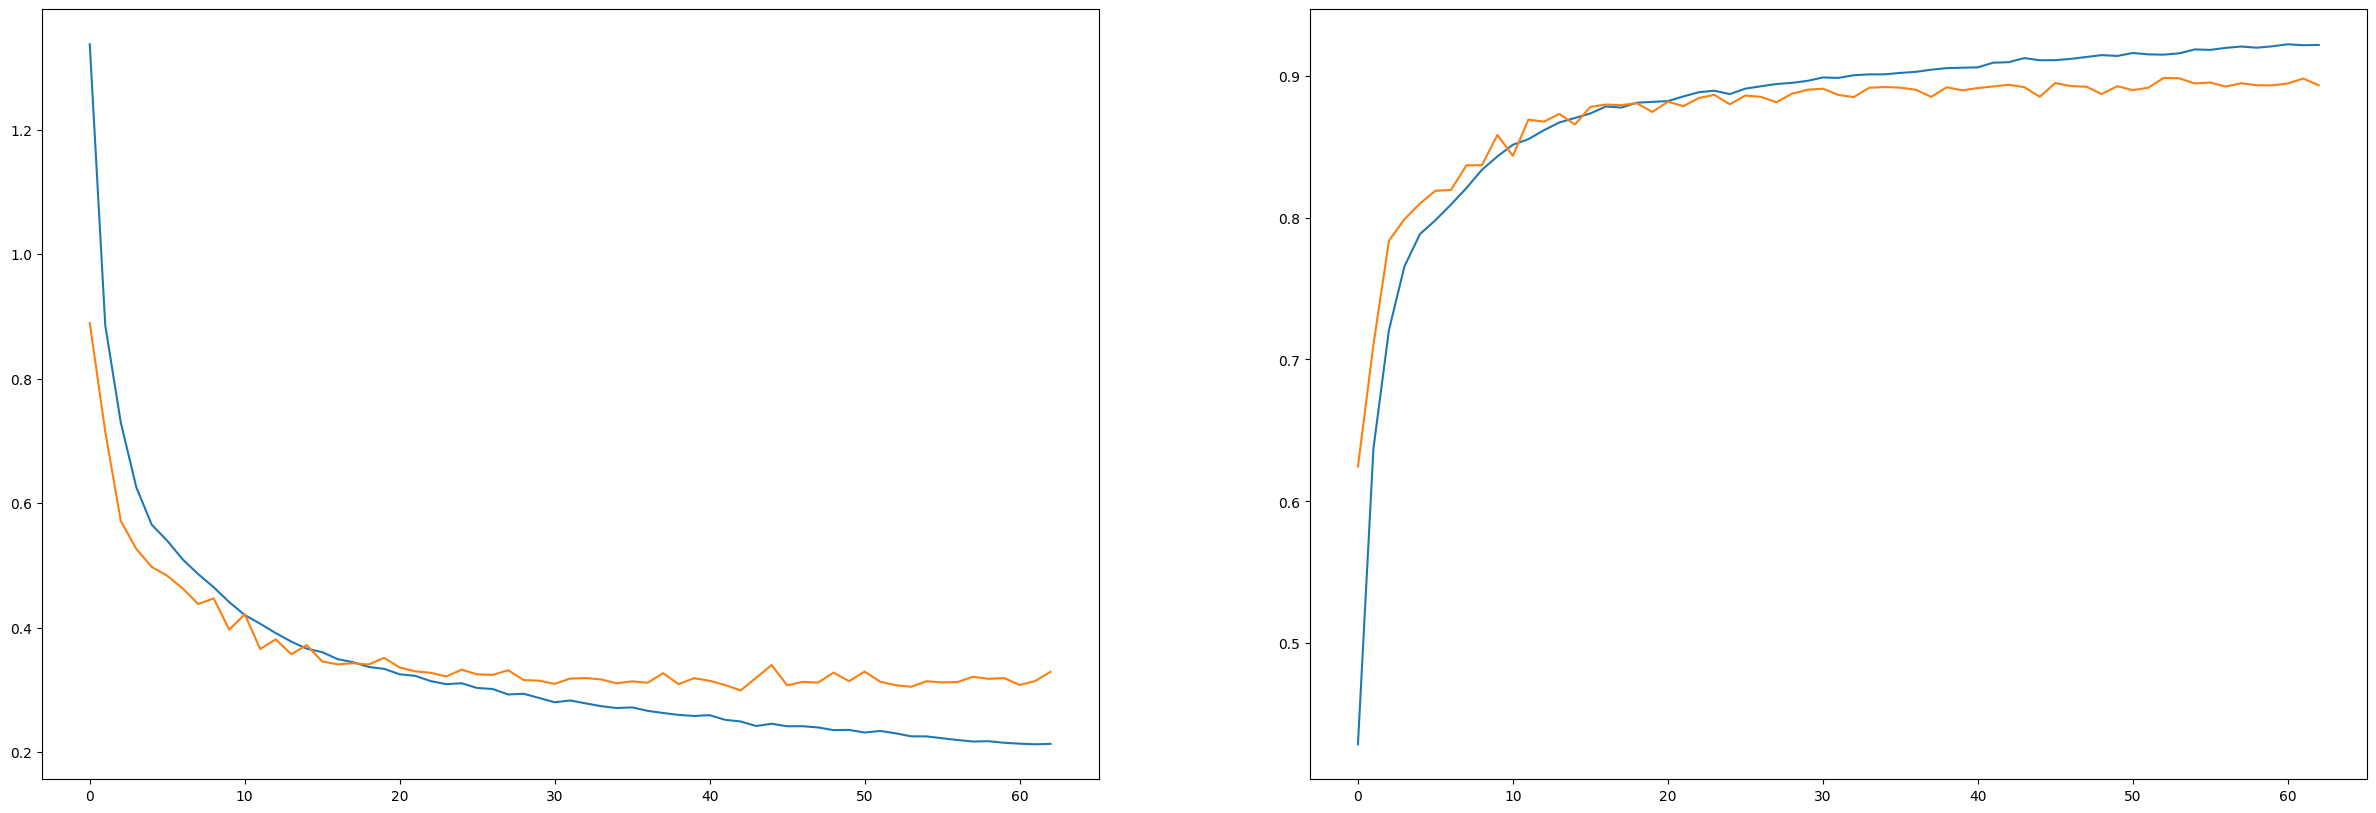

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.plot(model_six_layers.history.history['loss'])
ax1.plot(model_six_layers.history.history['val_loss'])
ax2.plot(model_six_layers.history.history['accuracy'])
ax2.plot(model_six_layers.history.history['val_accuracy'])